This code defines a function that performs a k-fold implementation of a random forests classifier and automatically calculates a number of performance metrics including ROC AUC, PR AUC, sensitivity,specificity and precision.

The code was used to generate a RF classifier identifying individuals with problematically low  gut microbiome alpha-diversity using a panel of 11 plasma metabolites. I further compared the performance of these identified metabolites with a large panel (p=74) of standard clinical labs to demonstrate that common lab tests measured in the clinical are unable to accurately capture gut microbiome perturbations, one of the key findings of the original paper.

The published paper can be found [here](https://www.nature.com/articles/s41587-019-0233-9).




In [1]:
# Load libraries
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import random
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#The RF_classifier() function trains a random forests classifier using a k-fold CV scheme. 
#It takes as input an indexed dataframe containing features and a binary outcome variable (outcome),
#CV parameter specifying number of k-folds and a class weight parameter when cases and control are unbalanced

#The function returns ROC AUC and PR AUC as well as specificity and sensitivity for each k-fold, 

def RF_classifier(df,outcome,CV=10,class_weight=[1,3.5]):
    X = df.loc[:,df.columns!=outcome]
    X.reset_index(inplace=True)
    X=X.loc[:,X.columns[2:]]
    print ('feature table shape',X.shape)
    X=np.array(X)
    y=np.array(df[outcome].tolist())
    reversed_mean_precision = 0.0
    mean_recall = np.linspace(0, 1, 100)
    mean_precision=[]
    pr_auc=[]
    aucs = []
    total_specificity=[]
    total_sensitivity=[]
    cv = StratifiedKFold(n_splits=CV)
    shannon_clf = RandomForestClassifier(n_estimators=2000,
                                 criterion='entropy',
                                 bootstrap=True, oob_score=False,class_weight={0:class_weight[0],1:class_weight[1]},
                                 max_features='sqrt',
                                 min_samples_split=2,
                                 min_samples_leaf=2,
                                 max_depth=5,
                                 random_state=1,
                                 n_jobs=-1)
    i = 0
    for train, test in cv.split(X, y):
        probas_ = shannon_clf.fit(X[train], y[train]).predict_proba(X[test])
        preds=shannon_clf.predict(X[test])
        tn, fp, fn, tp = confusion_matrix(y[test],preds).ravel()
        sensitivity=(tp/(tp+fn))
        specificity=(tn/(tn+fp))
        mean_precision.append(precision_score(y[test],preds))
        total_specificity.append(specificity)
        total_sensitivity.append(sensitivity)
        precision, recall, thresholds= precision_recall_curve(y[test], probas_[:, 1])
        pr_auc.append(auc(recall, precision))
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        reversed_recall = np.fliplr([recall])[0]
        reversed_precision = np.fliplr([precision])[0]
        reversed_mean_precision += interp(mean_recall, reversed_recall, reversed_precision)
        reversed_mean_precision[0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        report = 'Fold %d PR AUC=%.4f ROC AUC=%.4f' % (i+1, auc(recall, precision),roc_auc)
        print(report)
        i += 1
    reversed_mean_precision/= CV
    reversed_mean_precision[0] = 1
    print('Done! Mean ROC AUC={}(+/-{}) Mean PR AUCAUC={}(+/-{})'.format(round(np.mean(aucs),3),round(np.std(aucs),3),round(np.mean(pr_auc),3),round(np.std(pr_auc),3)))
    return aucs,pr_auc,total_specificity,total_sensitivity,mean_precision,reversed_mean_precision

In [3]:
#load data with 11 identified biomarkers and gut alpha-diversity measure (outcome)
#see how to access the data in the original published paper
df=pd.read_csv('metabolomics_discovery.csv')
#set index
df.set_index('public_client_id',inplace=True)
#load validation data with 11 biomarkers and gut alpha-diversity measure [different cohort,different microbiome sequencing vendor]
validation_df=pd.read_csv('metabolomics_validation.csv')
#set index
validation_df.set_index('public_client_id',inplace=True)
#bin Shannon diversity into quartiles
df['shannon']=pd.qcut(df['shannon'],4,labels=False)
validation_df['shannon']=pd.qcut(validation_df['shannon'],4,labels=False)
#recode the variable where the bottom quartile is a case (1,individual with problematically low diversity)
#and everyone else is a control (0)
def bottom_quartile(x):
    if x ==0:
        return 1
    elif x>0:
        return 0
df['shannon']= df['shannon'].apply(bottom_quartile)
validation_df['shannon']= validation_df['shannon'].apply(bottom_quartile)
#check if it worked
print('df shape:{}'.format(df.shape))
print('validation df shape:{}'.format(validation_df.shape))
df.groupby(by='shannon').size()

df shape:(399, 12)
validation df shape:(540, 12)


shannon
0    299
1    100
dtype: int64

In [4]:
#run RF analysis on discovery cohort and see how it compares to an external validation cohort
results=RF_classifier(df,'shannon',CV=10)
validation_results=RF_classifier(validation_df,'shannon',CV=10)

feature table shape (399, 10)
Fold 1 PR AUC=0.8073 ROC AUC=0.8433
Fold 2 PR AUC=0.5799 ROC AUC=0.8633
Fold 3 PR AUC=0.8050 ROC AUC=0.9000
Fold 4 PR AUC=0.6518 ROC AUC=0.8000
Fold 5 PR AUC=0.8081 ROC AUC=0.8600
Fold 6 PR AUC=0.6526 ROC AUC=0.8500
Fold 7 PR AUC=0.8190 ROC AUC=0.9233
Fold 8 PR AUC=0.8111 ROC AUC=0.9633
Fold 9 PR AUC=0.8606 ROC AUC=0.9100
Fold 10 PR AUC=0.8072 ROC AUC=0.9310
Done! Mean ROC AUC=0.884(+/-0.047) Mean PR AUCAUC=0.76(+/-0.09)
feature table shape (540, 10)
Fold 1 PR AUC=0.6638 ROC AUC=0.8011
Fold 2 PR AUC=0.5910 ROC AUC=0.8274
Fold 3 PR AUC=0.7285 ROC AUC=0.8912
Fold 4 PR AUC=0.7374 ROC AUC=0.8349
Fold 5 PR AUC=0.4373 ROC AUC=0.7486
Fold 6 PR AUC=0.6972 ROC AUC=0.8214
Fold 7 PR AUC=0.7422 ROC AUC=0.8268
Fold 8 PR AUC=0.7122 ROC AUC=0.8607
Fold 9 PR AUC=0.6438 ROC AUC=0.7589
Fold 10 PR AUC=0.7142 ROC AUC=0.8464
Done! Mean ROC AUC=0.822(+/-0.041) Mean PR AUCAUC=0.667(+/-0.089)


# One of the key findings of the original paper was that clinical laboratory tests most often used to assess the health state of an individual perform very poorly when predicting individual gut microbiome diversity scores.
# Below I used the 75+ standard clinical lab tests and evaluated how they perform in classifying individuals with very low (depleted) microbiome diversity

In [5]:
#Importing discovery cohort clinical labs data
chemistries_discovery=pd.read_csv('chemistries_git.csv')
#set index
chemistries_discovery['public_client_id']=chemistries_discovery['public_client_id'].astype('float64')
chemistries_discovery.set_index('public_client_id',inplace=True)
#add outcome variable
chemistries_discovery['shannon']=df['shannon']
print('chemistries df shape:{}'.format(chemistries_discovery.shape))

chemistries df shape:(399, 78)


In [6]:
#see how well clinical labs predict low microbiome diversity
clinical_lab_results=RF_classifier(chemistries_discovery,'shannon')

feature table shape (399, 76)
Fold 1 PR AUC=0.5711 ROC AUC=0.6300
Fold 2 PR AUC=0.5390 ROC AUC=0.6600
Fold 3 PR AUC=0.3790 ROC AUC=0.6033
Fold 4 PR AUC=0.5028 ROC AUC=0.6467
Fold 5 PR AUC=0.3574 ROC AUC=0.6467
Fold 6 PR AUC=0.6570 ROC AUC=0.7133
Fold 7 PR AUC=0.6370 ROC AUC=0.7467
Fold 8 PR AUC=0.4927 ROC AUC=0.6867
Fold 9 PR AUC=0.3732 ROC AUC=0.5900
Fold 10 PR AUC=0.5438 ROC AUC=0.7655
Done! Mean ROC AUC=0.669(+/-0.055) Mean PR AUCAUC=0.505(+/-0.101)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


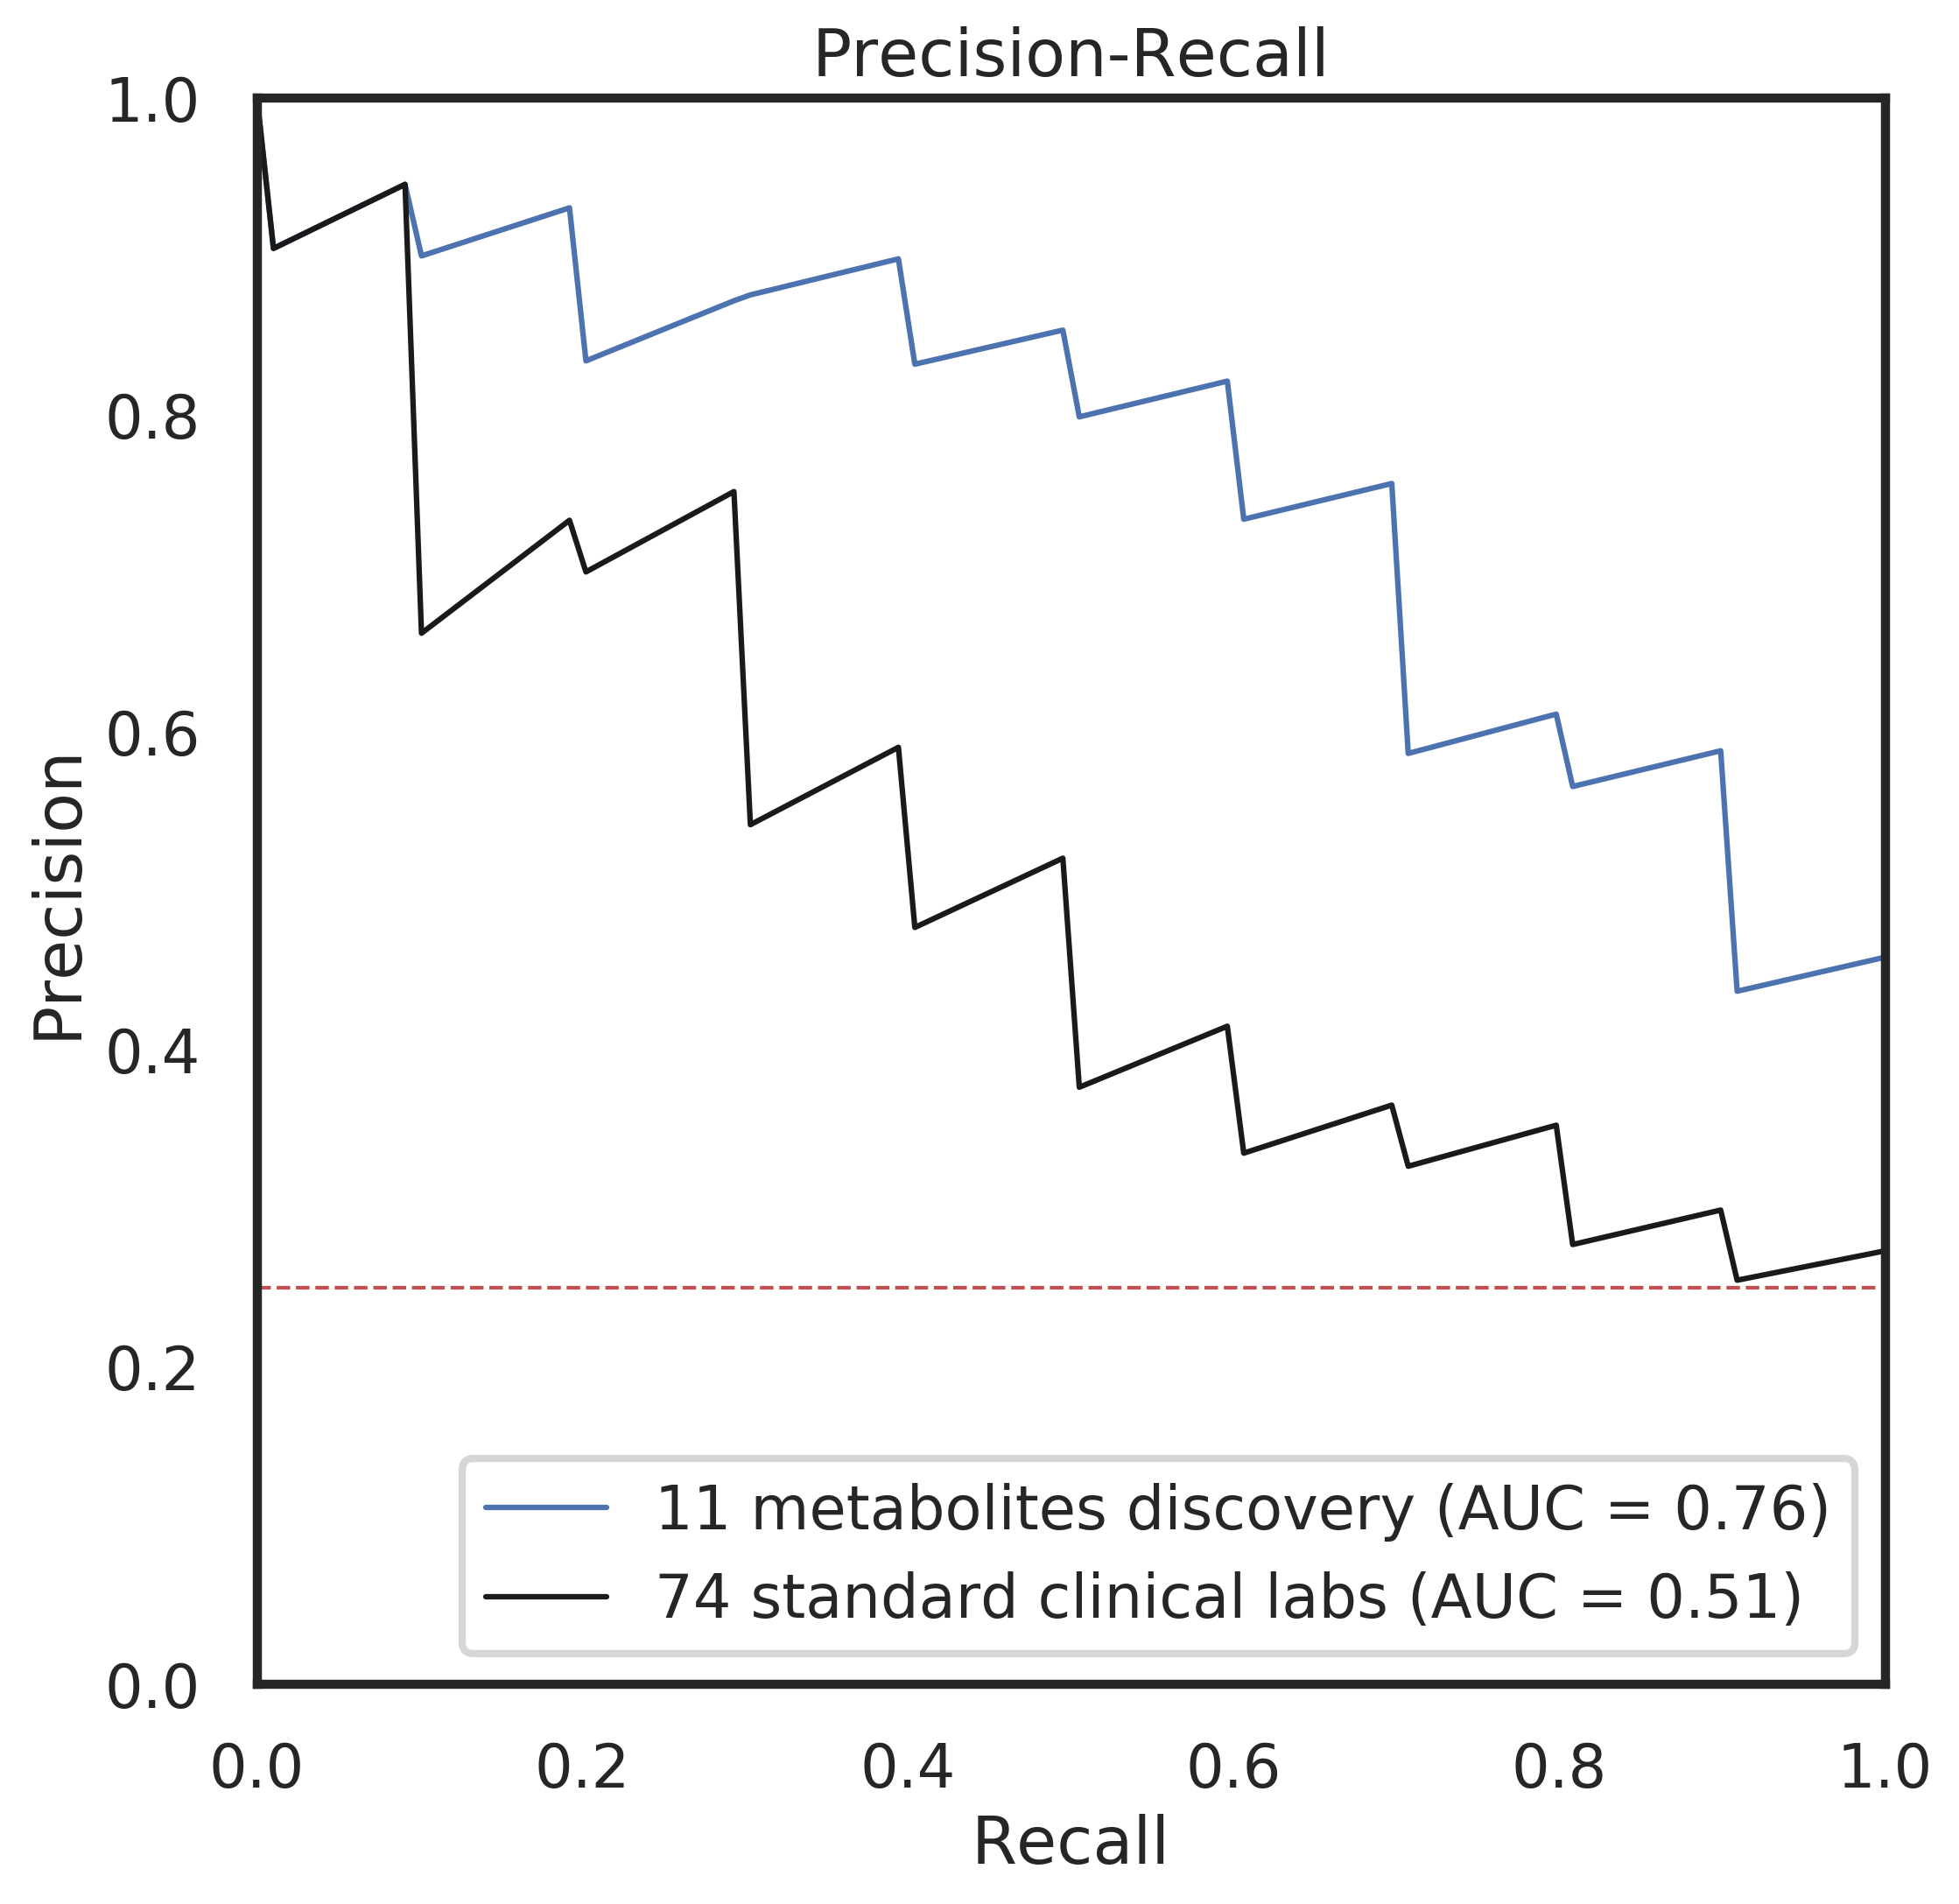

In [7]:
#Plotting PR curves to see how clinical labs and the identified metabolite biomarkers compare
plt.figure(figsize=(8,8), dpi=300)
sns.set(font_scale=.75,context='poster',font='Arial',style='white')
plt.plot(np.linspace(0, 1, 100),  ([results[5]])[0], 'b',
         label='11 metabolites discovery (AUC = %0.2f)' % np.mean(results[1]), lw=1.5)
plt.plot(np.linspace(0, 1, 100),  ([clinical_lab_results[5]])[0], 'k',
         label='74 standard clinical labs (AUC = %0.2f)' % np.mean(clinical_lab_results[1]), lw=1.5)
#random model performance
plt.hlines(0.25, 0, 1, colors='r', linestyles='--', label='',lw=1)
#plt.plot([1,0], [0,1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.plot()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.title('Precision-Recall')
plt.show()
#plt.savefig('precision-recall.png',dpi=200)